## 知识蒸馏-CTT teacher->DGRU student

In [1]:
import copy
import math
import torch
import pickle
import numpy as np
import pandas as pd
import geatpy as ea
from tqdm import tqdm
from torch import nn
from torch import optim
from fill.hot_filling import hot_fill
from fill.neighbour_filling import neighbour_fill
from filter.w_mean_filter import *
from filter.rssi_guass_filter import filter_guass
from filter.kalman_filter import filter_kalman
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils.calculate_param as cp
from dataset import data_read
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

/Users/frank/Desktop/jupyter/RFID_TRANS/filter/


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### 硬件设备准备

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 加载数据集 近邻填充+高斯滤波

In [3]:
X_train_0, y_train_0 = data_read.load_data('train')
X_test_0, y_test_0 = data_read.load_data('test')

In [4]:
X_train_neighbour = [neighbour_fill(xi) for xi in X_train_0]
X_test_neighbour = [neighbour_fill(xi) for xi in X_test_0]
X_train_guass = [filter_guass(xi) for xi in X_train_neighbour]
X_test_guass = [filter_guass(xi) for xi in X_test_neighbour]
X_train_guass = np.array(X_train_guass)
X_test_guass = np.array(X_test_guass)

X_train_guass.shape

(2000, 50)

In [5]:
X_train = torch.from_numpy(X_train_guass).float().to(device) # [len * feature]
y_train = torch.from_numpy(y_train_0).float().to(device)
X_test = torch.from_numpy(X_test_guass).float().to(device) # [len * feature]
y_test = torch.from_numpy(y_test_0).float().to(device)

X_train.shape


torch.Size([2000, 50])

In [6]:
train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=100, shuffle=False)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=100, shuffle=False)

### 定义教师模型-CTT

In [7]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out=nn.Linear(960, 50)

    def forward(self, x):
        x= self.conv1(x)
        # print(x.shape)
        x= self.conv2(x)
        # print(x.shape)
        x= x.view(-1, x.size(0) * x.size(1) * x.size(2))
        # print(x.shape)
        out = self.out(x)
        return out


# 位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        out = x + self.pe[:x.size(0), :]
        return out


# 教师模型类
class TeacherTransformer(nn.Module):
    def __init__(self):
        super(TeacherTransformer, self).__init__()
        self.cnn = CNN()
        self.d_model = 128  # 词向量维度
        self.embedding_enc = nn.Linear(50, self.d_model)
        self.embedding_dec = nn.Linear(2, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        self.Transformer_layer = nn.Transformer(d_model=128, num_encoder_layers=3, num_decoder_layers=3, batch_first=True)
        self.FC_layer = nn.Linear(128, 2)

    def forward(self, src, tgt):
        # rssi进行cnn特征提取
        src = src.unsqueeze(0)
        src = self.cnn(src)
        # print(src.shape)
        # 使用线性层代替embedding
        src = self.embedding_enc(src).unsqueeze(0)
        tgt = self.embedding_dec(tgt).unsqueeze(0)
        src = self.pos_encoding(src)
        out = self.Transformer_layer(src, tgt)
        out = self.FC_layer(out)
        return out


### 教师模型设置

In [8]:
model = TeacherTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

### 教师模型信息

In [9]:
# 输出教师模型的参数信息-380w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                                                 Param #
TeacherTransformer                                                     --
├─CNN: 1-1                                                             --
│    └─Sequential: 2-1                                                 --
│    │    └─Conv2d: 3-1                                                150
│    │    └─ReLU: 3-2                                                  --
│    │    └─MaxPool2d: 3-3                                             --
│    └─Sequential: 2-2                                                 --
│    │    └─Conv2d: 3-4                                                888
│    │    └─ReLU: 3-5                                                  --
│    │    └─MaxPool2d: 3-6                                             --
│    └─Linear: 2-3                                                     48,050
├─Linear: 1-2                                                          6,528
├─Linear:

### 教师模型训练

In [53]:
%%time

best_loss = 100000
best_epoch = 0
for epoch in range(150):
    epoch_loss = 0
    for X, y in train_data_loader:  # enc_inputs : [len * feature]->[2000 * 50]
        # print(X.shape)  # [100 * 50]
        # print(y.shape)  # [100 * 50]
        outputs = model(X, y)
        outputs = outputs.squeeze()  # [100 * 2]
        # print(outputs.shape)
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/ctt_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 129.998638
Epoch: 0002 loss = 47.602817
Epoch: 0003 loss = 42.132884
Epoch: 0004 loss = 37.284594
Epoch: 0005 loss = 28.369028
Epoch: 0006 loss = 19.852887
Epoch: 0007 loss = 12.045530
Epoch: 0008 loss = 10.521668
Epoch: 0009 loss = 9.377818
Epoch: 0010 loss = 6.554981
Epoch: 0011 loss = 4.498675
Epoch: 0012 loss = 4.578646
Epoch: 0013 loss = 4.446416
Epoch: 0014 loss = 3.611479
Epoch: 0015 loss = 2.867299
Epoch: 0016 loss = 3.022958
Epoch: 0017 loss = 2.838755
Epoch: 0018 loss = 2.951772
Epoch: 0019 loss = 2.784625
Epoch: 0020 loss = 2.155868
Epoch: 0021 loss = 2.203376
Epoch: 0022 loss = 2.301805
Epoch: 0023 loss = 1.971854
Epoch: 0024 loss = 1.692090
Epoch: 0025 loss = 1.646012
Epoch: 0026 loss = 1.750359
Epoch: 0027 loss = 1.609370
Epoch: 0028 loss = 1.515303
Epoch: 0029 loss = 1.694549
Epoch: 0030 loss = 1.409488
Epoch: 0031 loss = 1.695054
Epoch: 0032 loss = 1.545713
Epoch: 0033 loss = 1.238061
Epoch: 0034 loss = 1.355181
Epoch: 0035 loss = 1.561455
Epoch: 0036

### 教师模型评估

In [10]:
model = TeacherTransformer().to(device)
# 暂存教师模型为teacher_model
teacher_model = model
model.load_state_dict(torch.load('./result/ctt_weight.pth'))
model.eval()

pxy_all = []
y_all = []
for X, y in test_data_loader:
    pxy = model(X, y)
    pxy = pxy.cpu().detach().numpy().squeeze(0)
    y = y.cpu().detach().numpy()
    pxy_all.append(pxy)
    y_all.append(y)

# 计算指标
pxy_all = np.array(pxy_all).reshape(-1, 2)
y_all = np.array(y_all).reshape(-1, 2)
mae = mean_absolute_error(y_all, pxy_all)
mse = mean_squared_error(y_all, pxy_all)
rmse = mse ** 0.5
evs = explained_variance_score(y_all, pxy_all)
r2 = r2_score(y_all, pxy_all)

mmax = 0
mmin = 10000
for i in range(len(pxy_all)):
    mmax = max(mean_absolute_error(y_all[i], pxy_all[i]), mmax)
    mmin = min(mean_absolute_error(y_all[i], pxy_all[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

y_teacher = y_all[:20]
pxy = pxy_all[:20]
coor1 = pd.DataFrame(y_teacher)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_ctt.csv')
print(coor)

{'mae': 0.13338129, 'mse': 0.028472332, 'rmse': 0.16873746556071798, 'evs': 0.9949590265750885, 'r2': 0.9860217061275907, 'mmax': 0.35820603, 'mmin': 0.017809458}
       X     y        PX        Py
0   0.21  3.47  0.124531  3.715504
1   1.13  1.96  1.084291  2.080899
2   3.38  2.58  3.346277  2.748064
3   4.07  2.72  4.168088  2.933629
4   1.58  2.47  1.576717  2.598555
5   3.43  1.61  3.406310  1.756241
6   1.22  0.74  1.135537  0.773024
7   2.33  1.97  2.292284  2.134232
8   0.33  3.56  0.246293  3.826063
9   3.53  4.28  3.744175  4.694170
10  4.42  3.69  4.702496  4.065153
11  3.67  0.34  3.764961  0.363934
12  2.57  0.37  2.540435  0.417595
13  3.14  3.22  3.148333  3.386683
14  4.76  3.34  4.985601  3.633575
15  1.70  3.71  1.709826  3.943636
16  3.50  1.20  3.539850  1.304910
17  0.68  4.65  0.656825  4.929386
18  1.09  4.59  1.065913  4.934533
19  0.25  3.70  0.169071  3.974638


### 教师模型定位效果可视化

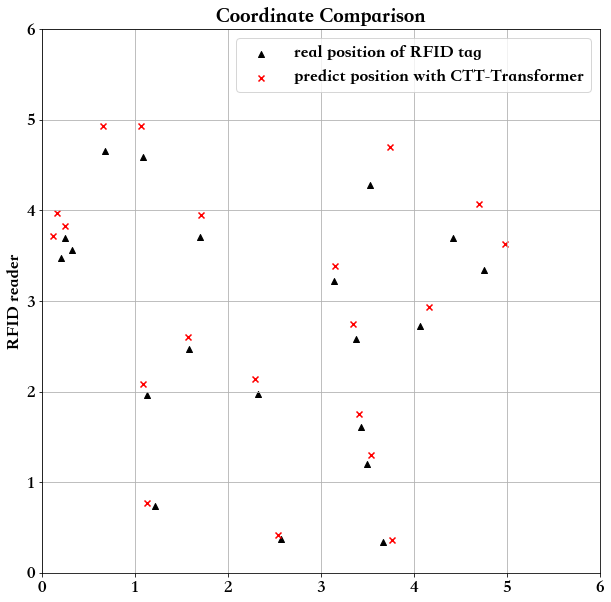

In [11]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_teacher[:, 0], y_teacher[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with CTT-Transformer')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_ctt.jpg', dpi=750, bbox_inches = 'tight')

### 定义学生模型-GRU模型

In [12]:
class StudentGRU(nn.Module):
    def __init__(self):
        super(StudentGRU, self).__init__()
        self.time_step = 50
        self.x_dim = 1
        self.h_dim = 60
        self.gru_layers = 1

        self.GRU_layer1 = nn.GRU(self.x_dim, self.h_dim, self.gru_layers, batch_first=True)
        self.GRU_layer2 = nn.GRU(self.x_dim, self.h_dim, self.gru_layers, batch_first=True)
        self.FC = nn.Linear(self.h_dim * 2, 2)

    def forward(self, x):
        a = x.cpu().detach().numpy()
        x2 = a[:, 1:, :] - a[:, :-1, :]
        # print(x2.shape)
        x2 = torch.from_numpy(x2).float().to(device)
        batch, time_step, x_dim = x.size()
        h0 = torch.zeros((self.gru_layers, batch, self.h_dim)).to(device)
        h0_2 = torch.zeros((self.gru_layers, batch, self.h_dim)).to(device)
        output, hn = self.GRU_layer1(x, h0)
        output2, hn2 = self.GRU_layer2(x2, h0)
        # print(hn.size(), hn2.size())
        res = hn.squeeze(0)
        res2 = hn2.squeeze(0)
        # print(res.size(), res2.size())
        out = torch.cat((res, res2), 1)
        # print(out.size())
        out = self.FC(out)
        return out


### 学生模型设置

In [13]:
# 从头先训练一下学生模型
model = StudentGRU().to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 学生模型信息

In [14]:
# 输出学生模型的参数信息-1w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                   Param #
StudentGRU                               --
├─GRU: 1-1                               11,340
├─GRU: 1-2                               11,340
├─Linear: 1-3                            242
Total params: 22,922
Trainable params: 22,922
Non-trainable params: 0


### 学生模型训练

In [15]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:
        outputs = model(X.unsqueeze(2))
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/student_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 95.708259
Epoch: 0002 loss = 37.272622
Epoch: 0003 loss = 28.609212
Epoch: 0004 loss = 18.956577
Epoch: 0005 loss = 10.280211
Epoch: 0006 loss = 7.076562
Epoch: 0007 loss = 6.068010
Epoch: 0008 loss = 5.755755
Epoch: 0009 loss = 5.907609
Epoch: 0010 loss = 5.150517
Epoch: 0011 loss = 4.909596
Epoch: 0012 loss = 4.890093
Epoch: 0013 loss = 4.908761
Epoch: 0014 loss = 4.551522
Epoch: 0015 loss = 4.364404
Epoch: 0016 loss = 4.559141
Epoch: 0017 loss = 4.280133
Epoch: 0018 loss = 4.529616
Epoch: 0019 loss = 4.228133
Epoch: 0020 loss = 4.087405
Epoch: 0021 loss = 4.422421
Epoch: 0022 loss = 4.775093
Epoch: 0023 loss = 3.998182
Epoch: 0024 loss = 4.074812
Epoch: 0025 loss = 3.987837
Epoch: 0026 loss = 3.952612
Epoch: 0027 loss = 4.013371
Epoch: 0028 loss = 3.848284
Epoch: 0029 loss = 3.894264
Epoch: 0030 loss = 3.752950
Epoch: 0031 loss = 3.797682
Epoch: 0032 loss = 4.442583
Epoch: 0033 loss = 3.730355
Epoch: 0034 loss = 3.779921
Epoch: 0035 loss = 4.036580
Epoch: 0036 los

### 学生模型评估

In [18]:
model = StudentGRU()
# 暂存不加蒸馏学生模型为student_model
student_model = model

model.load_state_dict(torch.load('./result/student_weight.pth'))
model.eval()

pxy = model(X_test.unsqueeze(2))
pxy = pxy.cpu().detach().numpy()
# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})


{'mae': 0.326116, 'mse': 0.20153688, 'rmse': 0.4489285900267918, 'evs': 0.9022361040115356, 'r2': 0.9010476883174683, 'mmax': 1.6254778, 'mmin': 0.017549396}


### 学生模型定位效果可视化

In [19]:
y_test = np.array(y_test)
y_student = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_student)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_student.csv')
coor

,X,y,PX,Py
0,0.21,3.47,0.377913,3.443006
1,1.13,1.96,1.114493,1.314993
2,3.38,2.58,3.239875,1.367922
3,4.07,2.72,3.897378,3.380611
4,1.58,2.47,1.591813,1.781291
5,3.43,1.61,2.937770,0.936035
6,1.22,0.74,1.401620,0.741646
7,2.33,1.97,2.187461,1.053290
8,0.33,3.56,0.399906,3.901588
9,3.53,4.28,3.447359,3.755456


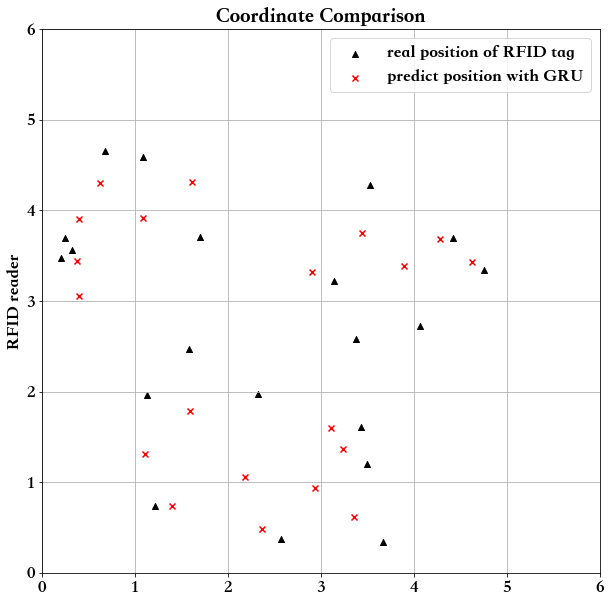

In [20]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_student[:, 0], y_student[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with GRU')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_student.jpg', dpi=750, bbox_inches = 'tight')

### 知识蒸馏准备与设置

In [26]:
# 准备预训练好的教师模型
teacher_model.eval()

# 准备新的学生模型
model = StudentGRU().to(device)

# 蒸馏温度
T = 7

# 参数设置
# hard_loss
hard_loss = nn.MSELoss()
# soft_loss kl散度
soft_loss = nn.KLDivLoss(reduction='batchmean')

alpha = 0.5
beta = 0.7
m = 0.9

# 回归分析的损失函数设置 = 平滑l1loss + beta * 范围loss
# loss = smoothl1loss + alpha * boundloss
loss1 = nn.SmoothL1Loss()
loss2 = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 知识蒸馏训练

In [27]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(150):
    epoch_loss = 0
    for X, y in train_data_loader:
        X, y = X.to(device), y.to(device)
        # 教师模型预测
        with torch.no_grad():
            teacher_outputs = teacher_model(X, y)
            teacher_outputs = teacher_outputs.squeeze(0)
        # 学生模型预测
        student_outputs = model(X.unsqueeze(2))
        # student_outputs = student_outputs[0]

        # student_loss = hard_loss(student_outputs, y)
        # # 计算蒸馏后的预测结果及soft_loss
        # distillation_loss = soft_loss(
        #     F.softmax(student_outputs/T, dim=1),
        #     F.softmax(teacher_outputs/T, dim=1)
        # )
        # # 将 hard_loss 和 soft_loss 加权求和
        # loss = alpha * student_loss + (1-alpha) * distillation_loss
        # 回归损失
        ls = loss2(student_outputs, y)
        lt = loss2(teacher_outputs, y)
        loss = loss1(student_outputs, y)  # smooth loss
        if ls.item() + m > lt.item():  # bound loss
            loss += beta * ls
        # 反向传播,优化权重
        optimizer.zero_grad()
        epoch_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/distillation_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 78.357907
Epoch: 0002 loss = 40.074273
Epoch: 0003 loss = 31.879605
Epoch: 0004 loss = 22.124946
Epoch: 0005 loss = 14.857875
Epoch: 0006 loss = 11.885685
Epoch: 0007 loss = 8.865809
Epoch: 0008 loss = 7.810835
Epoch: 0009 loss = 7.327664
Epoch: 0010 loss = 6.800116
Epoch: 0011 loss = 6.337935
Epoch: 0012 loss = 6.165665
Epoch: 0013 loss = 5.898129
Epoch: 0014 loss = 5.828645
Epoch: 0015 loss = 5.606550
Epoch: 0016 loss = 5.525194
Epoch: 0017 loss = 5.310095
Epoch: 0018 loss = 5.240070
Epoch: 0019 loss = 5.205168
Epoch: 0020 loss = 5.028372
Epoch: 0021 loss = 5.000242
Epoch: 0022 loss = 4.912551
Epoch: 0023 loss = 4.866844
Epoch: 0024 loss = 4.808741
Epoch: 0025 loss = 4.734767
Epoch: 0026 loss = 4.811490
Epoch: 0027 loss = 4.637875
Epoch: 0028 loss = 4.597332
Epoch: 0029 loss = 4.606039
Epoch: 0030 loss = 4.520107
Epoch: 0031 loss = 4.455851
Epoch: 0032 loss = 4.495187
Epoch: 0033 loss = 4.725837
Epoch: 0034 loss = 5.000397
Epoch: 0035 loss = 5.183834
Epoch: 0036 lo

### 蒸馏模型评估

In [28]:
model = StudentGRU()
model.load_state_dict(torch.load('./result/distillation_weight.pth'))
model.eval()

pxy = model(X_test.unsqueeze(2))
pxy = pxy.cpu().detach().numpy()
# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})


{'mae': 0.3189649, 'mse': 0.19230638, 'rmse': 0.43852751845720783, 'evs': 0.9072008430957794, 'r2': 0.9057464743449262, 'mmax': 1.3549786, 'mmin': 0.0070975423}


### 蒸馏模型定位效果可视化

In [29]:
y_distill = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_distill)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_distill.csv')
coor

,X,y,PX,Py
0,0.21,3.47,0.772327,3.905186
1,1.13,1.96,1.234808,1.544316
2,3.38,2.58,3.269284,1.728631
3,4.07,2.72,3.970196,3.178779
4,1.58,2.47,1.762700,1.832177
5,3.43,1.61,2.762077,1.688652
6,1.22,0.74,1.591895,0.707517
7,2.33,1.97,2.265127,1.450960
8,0.33,3.56,0.733696,4.180948
9,3.53,4.28,3.489599,3.862355


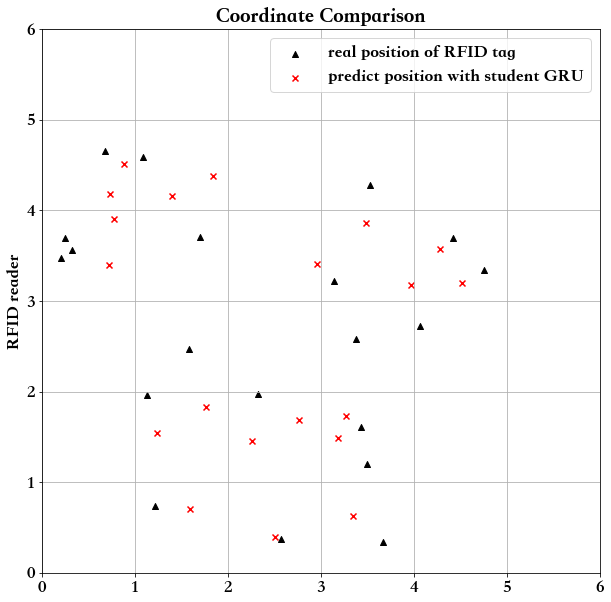

In [30]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_distill[:, 0], y_distill[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with student GRU')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_distill.jpg', dpi=750, bbox_inches = 'tight')

|### 定义问题类

In [19]:
class MOEA(ea.Problem):
    def __init__(self, train_data_loader, test_data_loader):
        name = 'MOEA'
        M = 1 # 初始化M（目标维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim) # 初始化varTypes 0-连续
        lb = [5, 0.1] # 决策变量下界
        ub = [10, 0.9] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader


    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        # print(Vars)
        pop.ObjV = np.zeros((pop.sizes, 1)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            epochs, alpha = int(Vars[i, 0]), float(Vars[i, 1])
            print(epochs, alpha)
            final_loss = 0
            for epoch in range(epochs):
                for data,targets in tqdm(train_data_loader):
                    data, targets = data.to(device), targets.to(device)
                    # 教师模型预测
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    # 学生模型预测
                    student_outputs = model(data)
                    student_loss = hard_loss(student_outputs, targets)
                    # 计算蒸馏后的预测结果及soft_loss
                    distillation_loss = soft_loss(
                        F.softmax(student_outputs/T, dim=1),
                        F.softmax(teacher_outputs/T, dim=1)
                    )
                    # 将 hard_loss 和 soft_loss 加权求和
                    loss = alpha * student_loss + (1-alpha) * distillation_loss
                    final_loss = loss.item()
                    # 反向传播,优化权重
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            pop.ObjV[i] = final_loss # 最小化最终的损失作为目标函数
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes))) # 散列种群每个个体进行加速计算


    # 代入优化后的参数先训练再对测试集进行检验，计算指标
    def test(self, epochs, alpha):
        for epoch in range(epochs):
            for data,targets in tqdm(train_data_loader):
                data, targets = data.to(device), targets.to(device)
                # 教师模型预测
                with torch.no_grad():
                    teacher_outputs = teacher_model(data)
                # 学生模型预测
                student_outputs = model(data)
                student_loss = hard_loss(student_outputs, targets)
                # 计算蒸馏后的预测结果及soft_loss
                distillation_loss = soft_loss(
                    F.softmax(student_outputs/T, dim=1),
                    F.softmax(teacher_outputs/T, dim=1)
                )
                # 将 hard_loss 和 soft_loss 加权求和
                loss = alpha * student_loss + (1-alpha) * distillation_loss
                # 反向传播,优化权重
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # 测试集上评估性能
            model.eval()
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x,y in test_data_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    pred = outputs.max(1).indices
                    num_correct += (pred == y).sum()
                    num_samples += pred.size(0)
                acc = (num_correct/num_samples).item()

            model.train()
            print("Epoch:{}\t Accuracy:{:4f}".format(epoch + 1, acc))

        torch.save(model.state_dict(), "./models/moea_distillation.pth")



### 参数调优

In [20]:
"""===============================实例化问题对象==========================="""

problem = MOEA(train_data_loader, test_data_loader) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 10             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 10 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')

"""=================================检验结果==============================="""

problem.test(epochs= int(BestIndi.Phen[0][0]), alpha= float(BestIndi.Phen[0][1]))


7 0.3189171239733696


6 0.2855765145272017


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:54, 17.05it/s]


6 0.8424268286675215



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:52, 17.78it/s]

  0%|          | 4/938 [00:00<00:51, 18.15it/s]

 94%|█████████▎| 878/938 [00:08<00:00, 102.62it/s]


  1%|          | 9/938 [00:00<00:48, 19.11it/s]]


6 0.8656420316547155


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:05, 14.39it/s]]


9 0.6277091335505247


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 4/938 [00:00<00:25, 37.06it/s]]

  1%|          | 10/938 [00:00<00:26, 34.80it/s]


  3%|▎         | 31/938 [00:00<00:23, 38.58it/s]

  4%|▍         | 38/938 [00:01<00:19, 45.81it/s]

  5%|▍         | 46/938 [00:01<00:16, 54.51it/s]

  6%|▌         | 54/938 [00:01<00:14, 61.32it/s]

  7%|▋         | 65/938 [00:01<00:11, 74.37it/s]

  8%|▊         | 76/938 [00:01<00:10, 83.75it/s]

  9%|▉         | 86/938 [00:01<00:09, 88.29it/s]

 10%|█         | 96/938 [00:01<00:09, 89.71it/s]

 11%|█▏        | 106/938 [00:01<00:09, 85.26it/s]

 12%|█▏        | 116/938 [00:01<00:09, 87.53it/s]

 13%|█▎        | 125/938 [00:02<00:09, 87.56it/s]

 14%|█▍        | 134/938 [00:02<00:09, 86.86it/s]

 15%|█▌        | 143/938 [00:02<00:09, 87.52it/s]

 16%|█▌        | 152/938 [00:02<00:09, 86.56it/s]

 17%|█▋        | 163/938 [00:02<00:08, 92.49it/s]

 19%|█▊        | 174/938 [00:02<00:08, 95.28it/s]

 20%|█▉        | 184/938 [00:02<00:08, 92.35it/s]


8 0.2740337282419205


100%|██████████| 938/938 [00:08<00:00, 116.82it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20, 10]], which is output 0 of AsStridedBackward0, is at version 23416; expected version 23415 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).